# Import Part

In [105]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, Flatten, MaxPooling2D, Input, BatchNormalization, LSTM
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import shutil
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from time import time
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import kaggle
import librosa
import pickle

# GPU Using

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus: 
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=5292)]
    )

logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")

1 Physical GPU, 1 Logical GPUs


# Kagggle API downloading

In [4]:
kaggle.api.dataset_download_files(dataset = "mehanat96/major-vs-minor-guitar-chords", path='dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/mehanat96/major-vs-minor-guitar-chords


# Setting parameters

In [237]:
DATA_DIR = "dataset"
SR = 11025 * 2 
N_MFCC = 40 
MAX_LEN = 100
LOG_DIR = "logs"
learning_rate = 0.001 
EPOCHS = 1000

# Extracting MFCC

In [238]:
def extract_features(file_path, sr=SR, n_mfcc=N_MFCC, max_len=MAX_LEN):
    try:
        audio, _ = librosa.load(file_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]
        return mfcc.T 
    except Exception as e:
        print(f"Ошибка обработки файла {file_path}: {e}")
        return None

# Audio download and preprocessing

In [239]:
def process_dataset(data_dir):
    X, y = [], []
    label_id = 0
    label_map = {}
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        label_map[label] = label_id
        print(f"Обработка папки: {class_dir}")
        print(f"Найдено файлов: {len(os.listdir(class_dir))}")
        for file in os.listdir(class_dir):
            if file.endswith(".wav"):
                file_path = os.path.join(class_dir, file)
                features = extract_features(file_path)
                if features is not None:
                    X.append(features)
                    y.append(label_id)
        label_id += 1
    return np.array(X), np.array(y), label_map

# Data transformation for training

In [240]:
X, y, label_map = process_dataset(DATA_DIR)
X = X[..., np.newaxis]
y = tf.keras.utils.to_categorical(y)

Обработка папки: dataset\major
Найдено файлов: 250
Обработка папки: dataset\minor
Найдено файлов: 250


In [241]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [246]:
cnn_model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(MAX_LEN, N_MFCC, 1), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(len(label_map), activation='softmax')
])

In [247]:
cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [248]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOG_DIR, histogram_freq=1)

In [249]:
with tf.device('/GPU:0'):
    early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=20,                
    min_delta=0.001,  
    restore_best_weights=True
    )
    history = cnn_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        callbacks=[tensorboard_callback, early_stopping]
    )

Epoch 1/1000
13/13 [==============================] - 1s 50ms/step - loss: 9.4774 - accuracy: 0.5575 - val_loss: 7.8912 - val_accuracy: 0.6800
Epoch 2/1000
13/13 [==============================] - 0s 36ms/step - loss: 8.5495 - accuracy: 0.5525 - val_loss: 8.2475 - val_accuracy: 0.4500
Epoch 3/1000
13/13 [==============================] - 0s 38ms/step - loss: 7.2217 - accuracy: 0.6325 - val_loss: 7.0694 - val_accuracy: 0.4700
Epoch 4/1000
13/13 [==============================] - 0s 37ms/step - loss: 6.5162 - accuracy: 0.6850 - val_loss: 6.4395 - val_accuracy: 0.4600
Epoch 5/1000
13/13 [==============================] - 0s 38ms/step - loss: 5.9946 - accuracy: 0.6850 - val_loss: 5.7594 - val_accuracy: 0.6000
Epoch 6/1000
13/13 [==============================] - 0s 38ms/step - loss: 5.4987 - accuracy: 0.7075 - val_loss: 5.4089 - val_accuracy: 0.5100
Epoch 7/1000
13/13 [==============================] - 0s 39ms/step - loss: 5.0616 - accuracy: 0.7225 - val_loss: 4.8850 - val_accuracy: 0.7700

In [250]:
loss, accuracy = cnn_model.evaluate(X_val, y_val)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")

4/4 [==============================] - 0s 4ms/step - loss: 0.9606 - accuracy: 0.9000
Validation Loss: 0.9606, Validation Accuracy: 0.9000


# Embeddings Visualisation

In [251]:
X_train_embeddings = embedding_model.predict(X_train)
X_val_embeddings = embedding_model.predict(X_val)

4/4 [==============================] - 0s 2ms/step


In [252]:
embeddings = np.concatenate([X_train_embeddings, X_val_embeddings])
labels = np.concatenate([y_train, y_val])

In [253]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
reduced_embeddings = tsne.fit_transform(embeddings)

E:\ProgramFiles\Anaconda\envs\NEW_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
E:\ProgramFiles\Anaconda\envs\NEW_GPU\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [254]:
if labels.shape[1] > 1:
    labels = np.argmax(labels, axis=1)


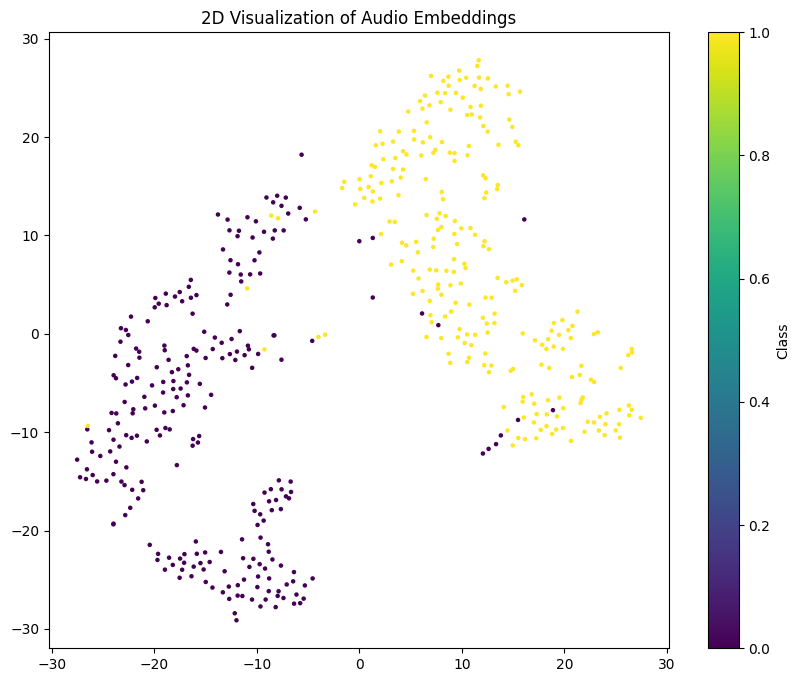

In [255]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=5)
plt.colorbar(label='Class')
plt.title('2D Visualization of Audio Embeddings')
plt.show()